*Parameter cells and Devices cells must be executed for any of the sections:
The sections of cells that must be executed are marked by  an astherisk as *

# Parameters and functions*

In [6]:
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
    !apt install ffmpeg

In [7]:
from tdgl.visualization.animate import create_animation
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.sources import ConstantField
from tdgl.geometry import box, circle
import matplotlib.pyplot as plt
#import default_functions as df
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os



In [8]:
# ====================================================
# Default configuration
# ====================================================
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
length_units = "um"     
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


In [9]:

###################################################################
#This script contains the default parameters and functions used in the notebook.#
###################################################################
# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

### 1.1. Material parameters
LENGTH_UNITS = "um"
xi = 0.5           
london_lambda = 2  
d = 0.1               
gamma = 10             
  # Ancho del puente (dimensión x)
 # Alto del puente (dimensión y)

STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping


### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100  

# ====================================================
## 2. ⚙️ videos and default functions
# ====================================================  
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)
def default_options(d_filename,skip_t=200,solve_t=200,saves=200):
    options =  tdgl.SolverOptions(
    skip_time=skip_t,  # initial relaxation time
    solve_time=solve_t,  # Real simulation time
    output_file=os.path.join(tempdir.name,d_filename),  # file route
    field_units="mT",  #Units of the applied field (miliTesla)
    current_units="uA",  # Units of the applied current (microamperios)
    save_every=saves,
    )
    return options
    
def default_solution(device,file_name,vector_potential=0,terminal_currents_applied=[0,0]):
    '''
    This function allows the user to apply different solution cases based on the applied current/field 
    :param device: tdgl.device object
    :param type_of_solution: String
    :param vector_potential: Double
    :param terminal_currents: unidimensional array [source_current,drain_current]
    Depending on the type_of_solution a solution is implemented
    '''
    options = default_options(file_name)
    external_field = ConstantField(vector_potential, field_units=options.field_units, length_units=device.length_units)
    solution = tdgl.solve(
         device,
         options,
         terminal_currents= dict(source=terminal_currents_applied[0],drain=terminal_currents_applied[1]),
         applied_vector_potential=external_field
        )
    return solution
# ====================================================
# 3.)Default configuration
# ====================================================
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0
# ====================================================
# 4.)Device Creation Function
# ====================================================
def plot_parameters(p1,p2,plot_labels,plot_type="plot",color_applied="teal"):
    plt.figure(figsize=(6, 4))
    if plot_type == "plot":
        plt.plot(p1,p2, "o-", color=color_applied)
    elif plot_type == "scatter":
        plt.scatter(p1,p2, "o-", color=color_applied)
    else:
        print("insert a valid plot type")
        return None
    plt.xlabel(plot_labels["x"])
    plt.ylabel(plot_labels["y"])
    plt.title(plot_labels["title"])
    plt.grid(True)
    plt.show()
    plt.savefig(plot_labels["fig_name"])
# ====================================================
## 4. ⚙️ Global Parameters(Optimized)
# ====================================================

def create_device(geometry_used,geometry_added,layer,max_edge_length,dimensions,translationx=0,incrementx=0.0,incrementy=0.0,translationy=0):
    '''
    Since we're using the same geometry, this function is implemented so we can change the dimensions of the right rectangle hence the position of the drain too : tdgl.polygon object,
    :param geometry_used: tdgl.polygon object,
    :param geometry_added: tdgl.polygon object,
    :param max_edge_length:int,
    :param incrementx:float
    :param incrementy:float
    :param source_dimension: array [width,height]
    :param drain_dimension: array [width,height]
    :param translationx:float
    :param translationy:float
    The translations move the source and drain along the polygon
    '''
    width_x = dimensions['width_x']
    height_y = dimensions['height_y']
    width_x2 = dimensions['width_x2']
    height_y2 = dimensions['height_y2']
    #for points that are the same as the  film width
    contact_size = width_x #1 µm squares
    real_size_x = width_x2 + incrementx
    real_size_y =3 + incrementy
    film_poly_up = tdgl.Polygon("film_pequeño", points=box(width=real_size_x, height= real_size_y)).translate(dx=+width_x/2)
    combined_geometry = geometry_used.union(geometry_added,film_poly_up)
    #Source
    source_poly = tdgl.Polygon(
        "source", 
        points=box(width=STRIPE_LENGTH,height=height_y2)
    ).translate(dx=-translationx).translate(dy=translationy)
    #Drain 
    drain_poly = tdgl.Polygon(
        "drain", 
        points=box(width=STRIPE_LENGTH, height=real_size_y)
    ).translate(dx=+translationx+incrementx/2).translate(dy=+translationy)
    combined_film = tdgl.Polygon.from_union([combined_geometry, source_poly, drain_poly], name="film")
    probe_points = [(width_x / 3,0), (-width_x / 3,0)]
    device = tdgl.Device(
        "vertical_bridge",
        layer=layer,
        film=combined_film,
        holes=[],
        terminals=[source_poly, drain_poly],
        probe_points=probe_points,
        length_units=LENGTH_UNITS,
    )
    device.make_mesh(max_edge_length=max_edge_length, smooth=SMOOTHING_STEPS)
    #Remove to se more details about the mesh 
    #There are 4 malformed cells as of now , 4/5030 
    clear_output(wait=True)
    print(f"  Malla creada: {len(device.mesh.sites)} puntos")
    fig, ax = device.draw()
    return device
    

def plot_solution(solution):
    '''
    Graphs the applied current on the device and the pahse for a fixed current/constant field 
    :param solution: tdgl.solution object
    '''
    #The plot_solution is only used on the 1st simulation section
    # Create figure with adjusted spacing and plot currents
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Wider figure (10 inches width)
    _ = solution.plot_currents(ax=axes[0], streamplot=False)
    _ = solution.plot_currents(ax=axes[1])  
    plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots
    plt.tight_layout()  # Automatically adjusts subplots to fit in figure
    plt.show()
    #Second plot
    # Plot a snapshot of the order parameter in the middle of a phase slip
    t0 = 155
    solution.solve_step = zero_field_solution.closest_solve_step(t0)
    fig, axes = solution.plot_order_parameter(figsize=(9, 10))
    plt.show()

# =========================
# 5) Magnetization function
# =========================
def solve_field(device,field,d=0.1):
    '''
    A function that applies a magnetic field sweep to a device and returns the corresponding magnetizations and magnetic moments.
    
    :param device: tdgl.device object
    :param field: List or array of magnetic field values to be applied.
    :param d: Double, depth of the superconductor in micrometers (default is 0.1 µm).
    :return: Two lists containing the total magnetic moments and volumetric magnetizations for each applied
    '''
    d = 0.1  # Superconductor depth in micrometers (µm)
    area = np.sum(device.areas)  # effective area of the device ( µm²)
    # =========================
    # 3) External Field sweep
    # =========================
    # Defines a list of 10 values for the external magnetic field form 0 to 1 mT
    moments = [] #total magnetic moment
    magnetizations = []  # volumetric magnetization
    m_solutions = []
    # Loop for each value of B

    with tempfile.TemporaryDirectory() as temp_dir:
        for B in field:
            # Creates a uniform magnetic field of magnitude B
            # Solves Ginzburg–Landau equations with an applied field
            solution_field= default_solution(device,"Bscan.h5",vector_potential=B,terminal_currents_applied=[0.0,0.0])
            #Calculates total magnetic moment (uA · µm²) 
            m = solution_field.magnetic_moment(units="uA * um**2", with_units=False)
            moments.append(m)  # Almacena el valor
            # Calculates volumetric magnetization: M = m / (Area ×depth)  in µA / µm³
            M = m / (area * d)
            magnetizations.append(M)
            
    # =========================
    # 4) Susceptibility dM/dB
    # =========================
    magnetizations = np.array(magnetizations)
    # Numeric derivation of the magnetization with respect to the field: dM/dB
    suceptibility = np.gradient(magnetizations, field)
    # =========================
    # 5)Save data on files
    # =========================
    np.savetxt("magnetization_vs_B.txt", np.column_stack((field, magnetizations)),header="B[mT] M[uA/um^3]")
    np.savetxt("suceptibilidad_rr_vs_B.txt", np.column_stack((field, suceptibility)),header="B[mT] dM/dB [uA/(um^3·mT)])
    return moments,magnetizations

def current_application(device,currents,B_field = 0):
    '''
    A function that applies a current sweep to a device and returns the corresponding voltages.
    
    :param device: tdgl.device object
    :param currents: List or array of current values to be applied.
    :param B_field: Double, optional magnetic field to be applied (default is 0).
    '''

    voltages = []
    # =========================================================
    # Simulation
    # =========================================================
    start_time = time.time()
    total_simulations = len(currents)
    j=0
    with tempfile.TemporaryDirectory() as temp_dir:
        for I in currents:
            solution_c = default_solution(
            device,
            f"solution_I_{I:.1f}.h5",
            vector_potential=B_field,
            terminal_currents_applied=[I, -I],
           )
            dynamics = solution_c.dynamics
            indices = dynamics.time_slice(tmin=120)
            voltage = np.abs(np.mean(dynamics.voltage()[indices]))
            voltages.append(voltage)
            j+=1
            print(f"I = {I:.1f} µA, <V> = {voltage:.4f} V₀,progress: {np.round(j/np.size(currents)*100,2)}%", end='\r')
        
  
    clear_output(wait=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_minutes = elapsed_time/60
    print(" " * 60, end='\r') 
    print("-" * 50)
    print(f"✅ The simulation was completed with {total_simulations} steps.")
    print(f"⏱️ The elapsed time was: {elapsed_time:.2f} seconds.")
    print(f"⏱️ The elapsed time was: {elapsed_minutes:.2f} minutes.")
    print(f"📊 Tiempo mean time per step was: {(elapsed_time / total_simulations):.2f} seconds.")
    print("-" * 50)
    return voltages
#Possible critic currents step optimizer function
def critic_currents_augmentation(device,critic_regions,currents,voltages,B= 0):
    '''
    A function that applies a current sweep to a device and returns the corresponding voltages with more resolution in critic regions.
    
    :param device: tdgl.device object
    :param critic_regions: List or array of current values where more resolution is needed.
    :param currents: List or array of current values to be applied.
    :param voltages: List or array of voltage values corresponding to the currents.
    :param B: Double, optional magnetic field to be applied (default is 0).
    '''
    size = np.size(currents)
    steps = 30
    epsilon = 1
    for i in critic_regions:
        co = i - epsilon
        cf = i + epsilon
        critic_currents = np.linspace(co, cf, steps)
        critic_voltages = current_application(device, critic_currents)
        #Masks for the currents
        mask_left = currents <= co 
        mask_right = currents >= cf
        #Masks for the voltages
        maskv1 = voltages <= critic_voltages
        maskv2 = voltages >= critic_voltages
        currents = np.concatenate((currents[mask_left],critic_currents,currents[mask_right]))
        voltages = np.concatenate((voltages[mask_left],critic_voltages[j],voltages[mask_right]))
    plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({currents[0]}–{currents[size]}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    plot_parameters(currents,voltages,plot_info1)
def varying_increments(device,currents,io,ifi,field = 0):
    size = ifi - io +1
    voltages_arr = []

    J = 0
    for h in range(io,ifi):      
        deltay = h
        if h == 3:
            deltay = 4
        device_l  =create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=deltay)#
        fig, ax = device_l.plot(mesh=False)
        voltages =  current_application(device_l, currents,B_field = field)
        voltages_arr.append(voltages)
        J+= 1
        print(f'progress: {np.round((J/size)*100,3)}')
    return voltages_arr
        

<>:305: SyntaxWarning: invalid escape sequence '\m'
<>:305: SyntaxWarning: invalid escape sequence '\D'
<>:305: SyntaxWarning: invalid escape sequence '\m'
<>:305: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alejo\AppData\Local\Temp\ipykernel_13476\2739613704.py:305: SyntaxWarning: invalid escape sequence '\m'
  plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({currents[0]}–{currents[size]}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
C:\Users\alejo\AppData\Local\Temp\ipykernel_13476\2739613704.py:305: SyntaxWarning: invalid escape sequence '\D'
  plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({currents[0]}–{currents[size]}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}


In [10]:

# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================
    
###Main rectangle
# Ancho del puente (dimensión x)
width_x = 5.0
# Alto del puente (dimensión y)
height_y = 12.0
STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 =(height_y/2)+ 1
dimensions = {"width_x":width_x,"width_x2": width_x/2,"height_y":height_y,"height_y2":height_y2}
### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100            
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )

widths: width_x:5.0,width_x2:2.5,height_y:12.0,height_y2:7.0,height_y2_altered:3


# Device*

Device and mesh creation

  Malla creada: 2944 puntos


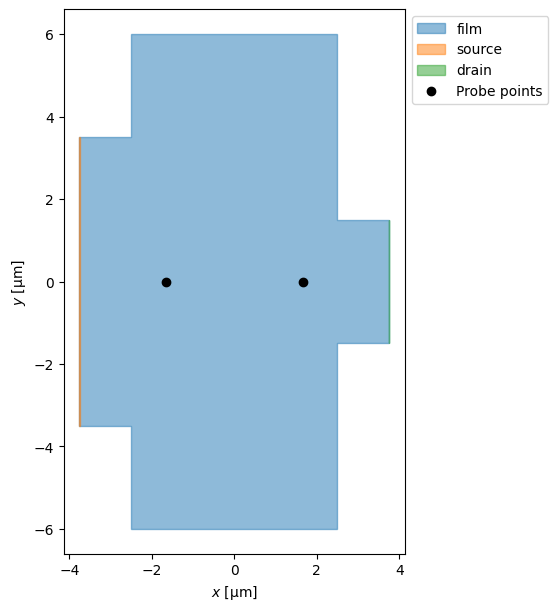

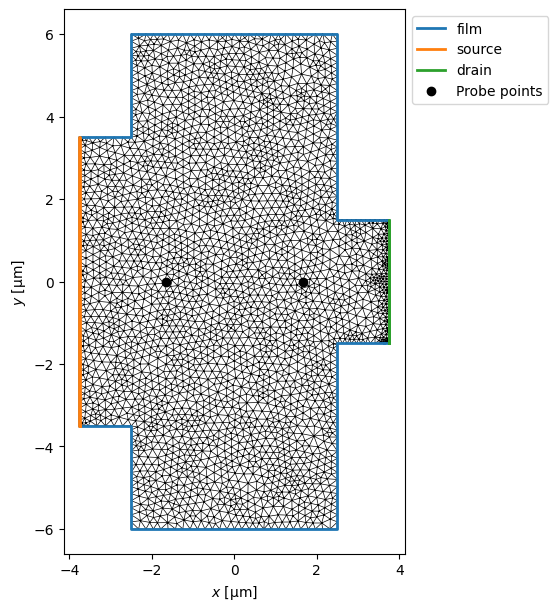

In [11]:
displacement = (width_x + width_x2 + STRIPE_LENGTH) / 2
device_fast = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement)
fig, ax = device_fast.plot(mesh=True)

# Simulations

## 1) Zero field for a fixed current

In [12]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 0.0)
plot_solution(zero_field_solution)

Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:51<00:00,  3.87tau/s ]


AttributeError: module 'default_functions' has no attribute 'plot_solution'

In [ ]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 1.0)
plot_solution(zero_field_solution)

In [ ]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 2.0)
plot_solution(zero_field_solution)

In [ ]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 3.0)
plot_solution(zero_field_solution)

In [ ]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[28,-28])

In [ ]:
# Create figure with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Wider figure (10 inches width)
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots
# Plot the currents
_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Evaluate sheet current density at cross-section
x = np.linspace(-width_x / 2, width_x / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T

plt.tight_layout()  # Automatically adjusts subplots to fit in figure
plt.show()

In [ ]:

# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 155
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(9, 10))
plt.show()

## 2)Zero Currents

### 2.1)Constant Field for zero current

In [ ]:
zero_current_solution =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

### 2.2)varying fields for zero current

In [ ]:
zero_current_solution_2 =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
zero_current_solution_3 =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=2.0)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
zero_current_solution_4 =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=3)
fig, axes = zero_current_solution_4.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
#if MAKE_ANIMATIONS:
#    zero_current_solution_video = make_video_from_solution(
#        zero_current_solution,
#        quantities=["order_parameter", "phase", "scalar_potential"],
#        figsize=(6.5, 4),
 
#    )
#    display(zero_current_solution_video)

### 2.3)Fixed field, zero current with different increments 

In [ ]:
device_1 = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=1)#h = 4
zero_current_solution_1 =  default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {1}')

In [ ]:
device_2 = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=2)#h = 5
zero_current_solution_2 =  default_solution(device_2, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {2}')

In [ ]:
device_3 = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=4)#h = y
zero_current_solution_3 =  default_solution(device_3, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {3}')

## 3)Magnetization

In [ ]:
# =========================
# 2) Applied field
# =========================
applied_field = np.linspace(0.0, 2, 10)  # External field on mT (B)
field_solutions,magnetization = solve_field(device_fast,applied_field)
plot_info = plot_labels={"fig_name":"currents.jpg","title":f'applied field vs magnetizations(0–1 mT)',"x":"B [$mT]","y":"magnetization"}
plot_parameters(applied_field, -magnetization,color_applied="red",plot_labels = plot_info)

## 4) varying currents

#### 4.1) Simulation with the default device

In [ ]:
co= 5
ci= 10 # current_interval
steps = 80
#currents = np.linspace(-ci, ci, steps)
currents = np.linspace(co, ci, steps)
# from -20 to 20 µA, step
voltages = current_application(device_fast, currents,B_field = 0)
actual_voltages = voltages 
plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}
µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
plot_parameters(currents,actual_voltages,plot_info1)

In [ ]:
#Possible critic currents step optimizer function
def critic_currents_augmentation(device,critic_regions,currents,voltages,B= 0):
    size = np.size(currents)
    steps = 30
    epsilon = 1
    for i in critic_regions:
        co = i - epsilon
        cf = i + epsilon
        critic_currents = np.linspace(co, cf, steps)
        critic_voltages = current_application(device, critic_currents,B = 0)
        #Masks for the currents
        mask_left = currents <= co 
        mask_right = currents >= cf
        #Masks for the voltages
        maskv1 = voltages <= critic_voltages
        maskv2 = voltages >= critic_voltages
        currents = np.concatenate((currents[mask_left],critic_currents,currents[mask_right]))
        voltages = np.concatenate((voltages[mask_left],critic_voltages[j],voltages[mask_right]))
    plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({currents[0]}–{currents[size]}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    plot_parameters(currents,voltages,plot_info1)

### 4.2)Different fields with varying currents

In [ ]:
for applied_field in range(1,4):
    voltages = current_application(device_fast, currents,B_field =applied_field)
    actual_voltages = voltages 
    plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}
    µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    plot_parameters(currents,actual_voltages,plot_info1)

In [ ]:
plt.title(f'Curva Voltaje vs Corriente ({co}–{ci} µA)')
plt.xlabel("Corriente $I$ [$\mu$A]")
plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")
plt.scatter(currents,actual_voltages[0],'--g')
plt.scatter(currents,actual_voltages[1],'--r')
plt.scatter(currents,actual_voltages[2],'--b')
plt.plot()

### 4.3) Zero field with varying currents and device modifications

In [ ]:
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )


In [ ]:
#height2 = de 4 a 7
io = 1
ifi = 4
size = ifi - io +1
voltages_arr = []
devices_arr = []


   

The function varying increments is explicitly shown here to test if it works 

In [ ]:
def varying_increments(device,currents,io,ifi,field = 0):
    size = ifi - io +1
    voltages_arr = []

    J = 0
    for h in range(io,ifi):      
        deltay = h
        if h == 3:
            deltay = 4
        device_l  = create_device(device,MAX_EDGE_LENGTH_IV,incrementy=deltay)
        fig, ax = device_l.plot(mesh=False)
        voltages =  current_application(device_l, currents,B_field = field)
        voltages_arr.append(voltages)
        J+= 1
        print(f'progress: {np.round((J/size)*100,3)}')
    return voltages_arr
        

In [ ]:
voltages_arr = varying_increments(half_geometry,currents,io,ifi)

In [ ]:
for j in range(0,3):
    plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}

    plot_parameters(currents,voltages_arr[j],plot_info2)

# Default functions
the primary functions to create new variations of the previous sections are:
 * create_device(geometry_used,max_edge_length,increment=3,translationx=((width_x + width_x2 + STRIPE_LENGTH) / 2),translationy=0)
 * current_application(device,currents)
 * plot_parameters(p1,voltages,plot_labels,plot_type="plot",color_applied="teal")